# 🌎⚖️📏 Fit a Mass-Radius Relation

This notebook fits for a mass-radius relationshhip with an intrinstic scatter, incorporating uncertainties in both dimensions. Since some planets have interesting/useful atmosphere constraints worth including in a cosmic shoreline (LHS 3844b, some small Solar System bodies) but no measured masses, we can use the mass radius relation derived here to estimate their masses and (cautious) uncertainties on those masses. 

## ☄️🌕🌎🪐 Load planet data.

We'll use [`exoatlas`](https://zkbt.github.io/exoatlas/) to download some catalogs of exoplanet and Solar System properties. The first time this runs it might be a little slow because it needs to download big tables from the NASA Exoplanet Archive, but from then onward it should be a bit faster. 

In [1]:
from shoreline import *

In [2]:
exoplanets = TransitingExoplanets()
major = SolarSystem()
dwarf = SolarSystemDwarfPlanets()
moons = SolarSystemMoons()
minor = SolarSystemMinorPlanets()

Let's make a quick plot to understand what data we're working with. We'll use some built-in [`Plottable` objects from `exoatlas`](https://zkbt.github.io/exoatlas/user/visualizing/) to visualize these populations togehther.

In [3]:
from exoatlas.visualizations import * 

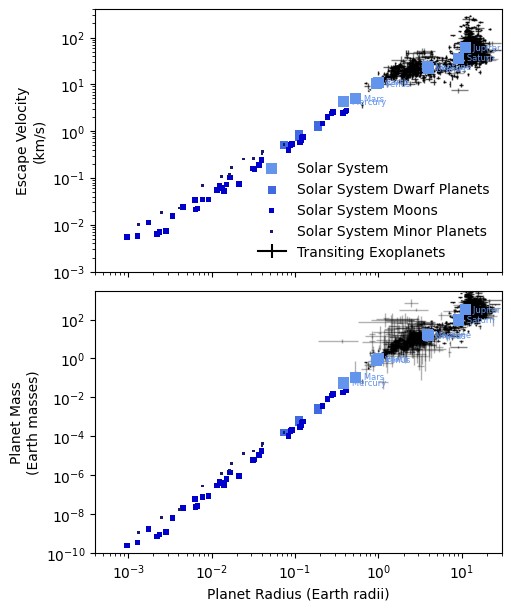

In [4]:
populations = [exoplanets, major, dwarf, moons, minor]
major.annotate_planets = True
g = GridGallery(rows=[EscapeVelocity(lim=[1e-3, 4e2]), Mass(lim=[1e-10, 3e3])], 
                cols=[Radius(lim=[4e-4, 3e1])], map_type=ErrorMap)
g.build(populations)
list(g.maps.values())[0].add_legend()

## 💾 Curate the data. 

Now, let's extract one big [`astropy.table`](https://docs.astropy.org/en/stable/table/index.html) of quantities we'll consider in our fit. 

In [5]:
for p in populations:
    p.add_column('type', p.label)
data = vstack([p.create_table(['name', 'type', 'radius', 'radius_uncertainty', 'mass', 'mass_uncertainty']) for p in populations])

# replace 0 uncertainties with 1% (but keep nan values)
for k in ['radius', 'mass']:
    i = (data[f'{k}_uncertainty'] == 0) | np.isnan(data[f'{k}_uncertainty'])
    data[f'{k}_uncertainty'][i] = data[f'{k}'][i]*0.01

We want to fit for a power-law relation $M \propto R^m$. Practically, it's easier to implement that as a straight line in log-transformed data. Let's define our axes, and set up $\sf x, y, \sigma_x, \sigma_y$. 

$$\sf x,i = \ln R_i$$
$$\sf y,i = \ln M_i$$
$$\sf \sigma_{x,i} = \frac{\sigma_{R,i}}{R_i}$$
$$\sf \sigma_{y,i} = \frac{\sigma_{M,i}}{M_i}$$


Let's extract the data we need, log-transform it, estimate log-transformed uncertainties, and plot them to make sure they make sense.

/Users/zabe0091/miniconda3/envs/exoatlas/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


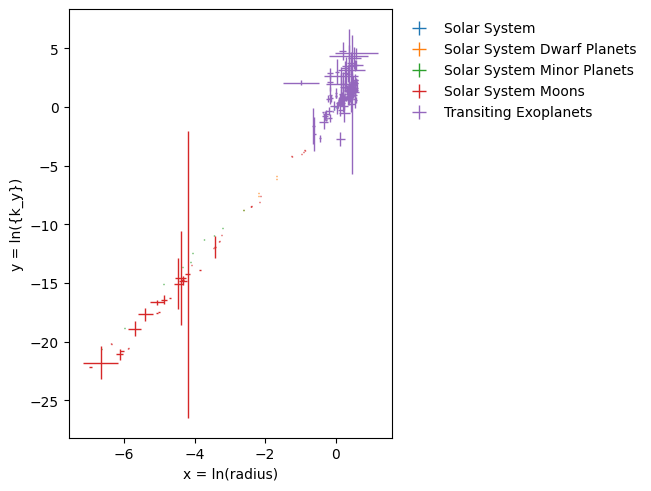

In [6]:
k_x, k_y = 'radius', 'mass'
rocky_radius_cutoff = 1.8*u.Rearth
ok = data['radius'] < rocky_radius_cutoff 

for k in [k_x, k_y]:
    for suffix in ['', '_uncertainty']:
        ok *= np.isfinite(data[f'{k}{suffix}'])
        ok *= data[f'{k}{suffix}']>0
    fractional_uncertainty = data[f'{k}_uncertainty']/data[k]
    #ok *= fractional_uncertainty < 0.25
    data[f'{k}_uncertainty'] = np.maximum(data[f'{k}_uncertainty'], 0.01*data[k])
    
subset = data[ok]
x = jnp.log(subset[f'{k_x}'].value)
y = jnp.log(subset[f'{k_y}'].value)
sigma_x = jnp.array(subset[f'{k_x}_uncertainty'].value/subset[f'{k_x}'].value)
sigma_y = jnp.array(subset[f'{k_y}_uncertainty'].value/subset[f'{k_y}'].value)

# make (approximate) covariance matrices for each data point
N = len(subset)
S = np.zeros((N, 2, 2))
S[:,0,0] = sigma_x**2
S[:,1,1] = sigma_y**2
S = jnp.array(S)
    
plt.figure(constrained_layout=True)
ekw = dict(linewidth=0, elinewidth=1)

for t in np.unique(subset['type']):
    i = subset['type'] == t
    plt.errorbar(x[i], y[i],  xerr=sigma_x[i], yerr=sigma_y[i], label=t, **ekw)
    plt.xlabel(f'x = ln({k_x})'); plt.ylabel('y = ln({k_y})')
plt.legend(frameon=False, bbox_to_anchor=(1,1))

## 🧑‍🎨 Define a model. 

Let's follow [this outline from D. Foreman-Mackey](https://dfm.io/posts/fitting-a-plane/), with some extra context from [D. Hogg et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010arXiv1008.4686H/abstract) and [J. Vanderplas (2014)](https://ui.adsabs.harvard.edu/abs/2014arXiv1411.5018V/abstract) (see also [this blog post](https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/#Prior-on-Slope-and-Intercept)). We'll be fitting a model that looks like 

$$\sf y = m\cdot x + b = m \cdot ln R + b$$

with an instrinsic scatter in the y direction (beyond the measurement uncertainties of any particular planet) of 

$$\sf ln \sigma_{y} = m_\sigma \cdot x + b_\sigma =  m_\sigma\cdot ln R + b_\sigma  $$

As explained into 


## ⏳ Infer the model parameters.

In [7]:
import numpyro


def model(x, y, S):
    m = numpyro.sample("m", numpyro.distributions.Normal(0, 10))
    b = numpyro.sample("b", numpyro.distributions.Normal(0, 10))
    m_sigma = numpyro.sample("m_sigma", numpyro.distributions.Normal(0, 10))
    b_sigma = numpyro.sample("b_sigma", numpyro.distributions.Normal(0, 10))
    log_sigma = m_sigma * x + b_sigma
    instrinsic_scatter = jnp.exp(log_sigma)

    # a vector pointing perpendicular to the line
    v = jnp.array([-m, 1.0])

    # the effective error in the direction between the line and the data point
    Sigma2 = jnp.dot(jnp.dot(S, v), v) + instrinsic_scatter**2

    # the offset in the y direction
    Delta = m * x + b - y

    # the product of all the individual likelihoods
    log_likelihood = -0.5 * jnp.sum(Delta**2 / Sigma2 + jnp.log(Sigma2))
    numpyro.factor("log_likelihood", log_likelihood)

    # a non-informative prior to avoid large prior space near infinite slope
    numpyro.factor("log_prior_for_m", -1.5 * jnp.log(1 + m**2))
    numpyro.factor("log_prior_for_m_sigma", -1.5 * jnp.log(1 + m_sigma**2))


import arviz as az
import jax
import corner


# sample from the prior
n_prior_samples = 5000
key = jax.random.key(0)
prior_samples = numpyro.infer.Predictive(model, num_samples=n_prior_samples)(
    key, x, y, S
)
converted_prior_samples = {
    f"{p}": np.expand_dims(prior_samples[p], axis=0) for p in prior_samples
}
prior_samples_inference = az.from_dict(converted_prior_samples)

az.summary(prior_samples_inference)

# sample from the posterior
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        model,
    ),
    num_warmup=5000,
    num_samples=50000
    ,
    num_chains=4,
    progress_bar=True,
)
sampler.run(jax.random.key(1), x, y, S)
inference = az.from_numpyro(sampler)

/Users/zabe0091/miniconda3/envs/exoatlas/lib/python3.13/site-packages/arviz/data/io_dict.py:89: UserWarning: log_likelihood variable found in posterior group. For stats functions log likelihood data needs to be in log_likelihood group.
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/55000 [00:00<?, ?it/s]

In [8]:
var_names=['m', 'b','m_sigma', 'b_sigma']
az.summary(inference, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,3.375,0.029,3.321,3.429,0.0,0.0,166902.0,136422.0,1.0
b,0.044,0.034,-0.020,0.108,0.0,0.0,173898.0,135550.0,1.0
m_sigma,-0.173,0.035,-0.240,-0.109,0.0,0.0,135902.0,137630.0,1.0
b_sigma,-1.024,0.102,-1.214,-0.830,0.0,0.0,140438.0,141314.0,1.0


## 🎨 Visualize the posterior.

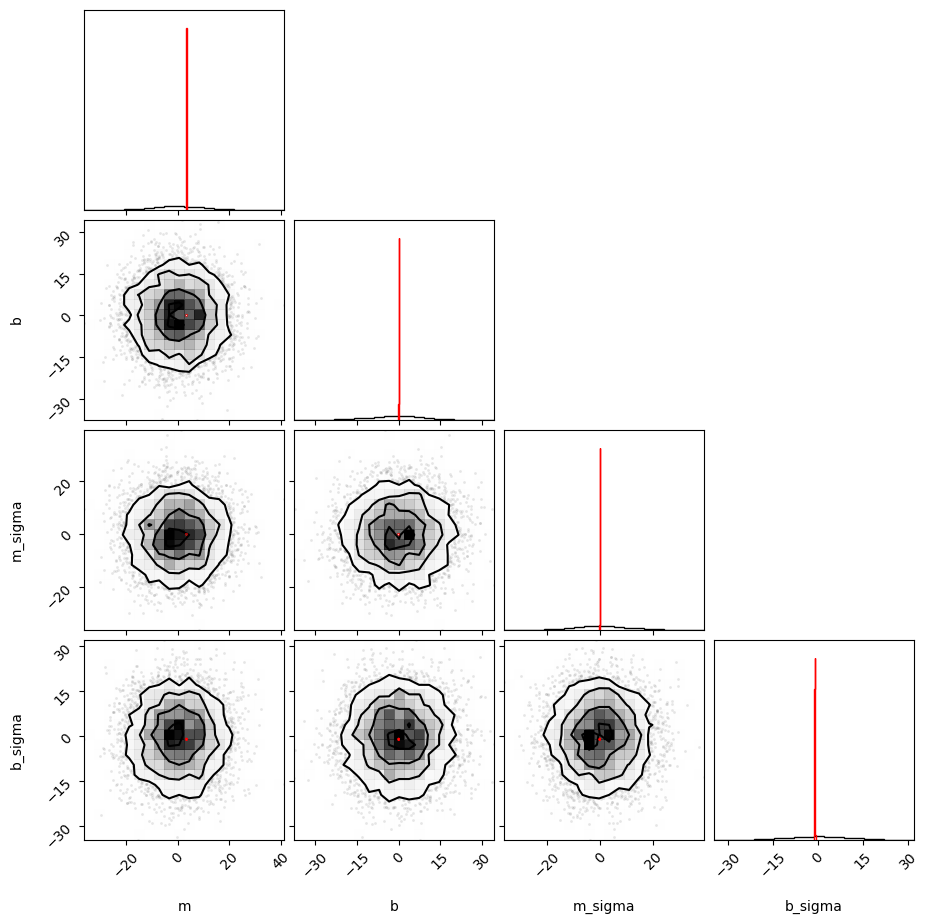

In [9]:
fig = corner.corner(prior_samples_inference, colors='black', var_names=var_names)
fig = corner.corner(inference,  color='red', fig=fig, var_names=var_names);

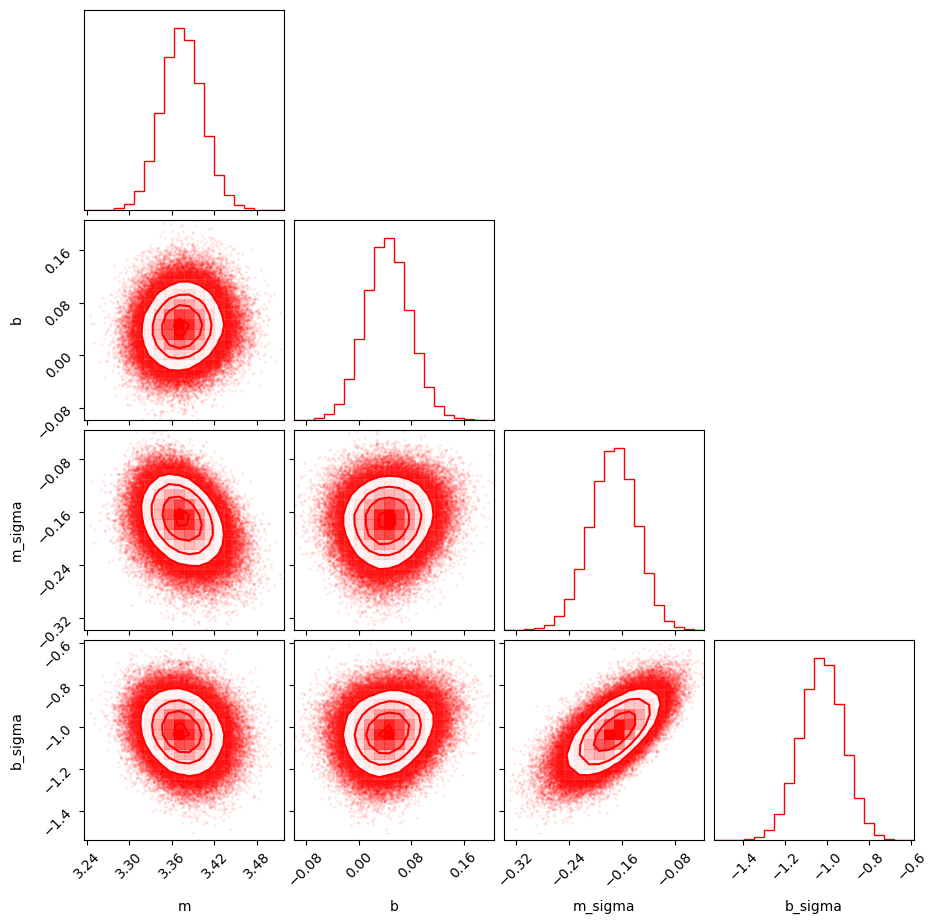

In [10]:
fig = corner.corner(inference,  color='red', var_names=var_names);

## 🖋️ Plot the new mass-radius relationship.

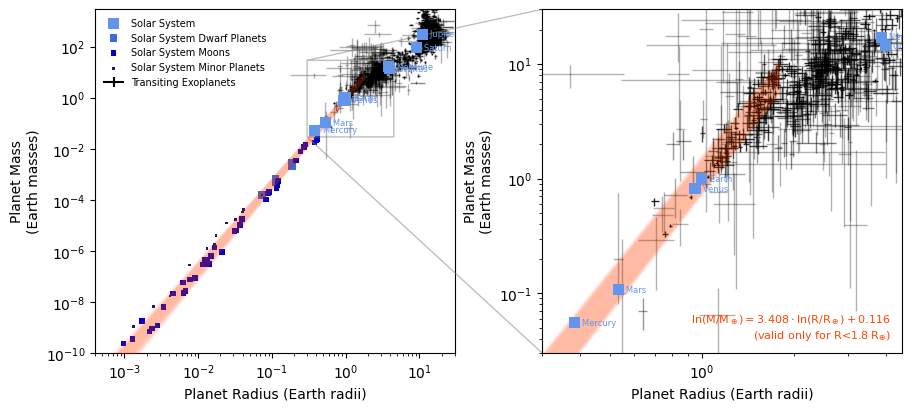

In [11]:
fi, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(9,4))

e = ErrorMap(xaxis=Radius(lim=[4e-4, 3e1]), yaxis=Mass(lim=[1e-10, 3e3]))
e.build(populations, ax=ax[0])
e.add_legend(loc='upper left', fontsize=7)

z = ErrorMap(xaxis=Radius(lim=[.3, 4.5]), yaxis=Mass(lim=[.03, 30]))
z.build(populations, ax=ax[1])

x_smooth = np.linspace(np.log(1e-4), np.log(rocky_radius_cutoff.to_value(u.Rearth)))

N = 20
samples = az.extract(inference, num_samples=N)

for a in ax:
    plt.sca(a)
    for i in range(N):
        b = samples.b.values[i]
        m = samples.m.values[i]
        y_center = m*x_smooth + b
    
        m_sigma = samples.m_sigma.values[i]
        b_sigma =  samples.b_sigma.values[i]
        log_sigma = m_sigma*x_smooth + b_sigma
        delta_y = np.exp(log_sigma)
        plt.fill_between(np.exp(x_smooth), np.exp(y_center+delta_y), np.exp(y_center-delta_y), linewidth=0, alpha=0.02, color='orangered', zorder=10)
        #plt.plot(np.exp(x_smooth), np.exp(m*x_smooth + b), color='orangered', alpha=0.02)
ax[0].indicate_inset_zoom(ax[1])
plt.sca(ax[1])

plt.text(0.97, 0.03, f'$\sf ln (M/M_\oplus) = {m:.3f} \cdot ln (R/R_\oplus) {b:+.3f}$\n(valid only for R<{rocky_radius_cutoff.to_string(format="latex_inline")})', 
         transform=ax[1].transAxes, fontsize=8,
         va = 'bottom', ha='right', color='orangered')# $\n$\sf ln \sigma_{{ln M}} =  m_\sigma\cdot ln R + b_\sigma$'



plt.savefig('figures/mass-radius-relation-for-rocky-planets.pdf')

## 🥏 Print parameters and covariance matrix.

We'd like to use the parameters we inferred from this fit to estimate the masses of other planets. Let's print out a snippet of code that we can paste into another code to represent both the mean parameters $\mu$ and their covariance matrix $\Sigma$.

In [12]:
summary = az.summary(inference, var_names=var_names)#, stat_focus='median')
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,3.375,0.029,3.321,3.429,0.0,0.0,166902.0,136422.0,1.0
b,0.044,0.034,-0.020,0.108,0.0,0.0,173898.0,135550.0,1.0
m_sigma,-0.173,0.035,-0.240,-0.109,0.0,0.0,135902.0,137630.0,1.0
b_sigma,-1.024,0.102,-1.214,-0.830,0.0,0.0,140438.0,141314.0,1.0


In [13]:
for k in summary['mean'].keys():
    print(f'{k} = {summary["mean"][k]} \pm {summary["sd"][k]}')

m = 3.375 \pm 0.029
b = 0.044 \pm 0.034
m_sigma = -0.173 \pm 0.035
b_sigma = -1.024 \pm 0.102


In [14]:
mu = summary['mean']
mu

m          3.375
b          0.044
m_sigma   -0.173
b_sigma   -1.024
Name: mean, dtype: float64

In [15]:
b_sigma = summary['mean']['b_sigma']
m_sigma = summary['mean']['m_sigma']

R = np.array([1, 1e-3])
np.exp(np.log(R)*m_sigma + b_sigma)



array([0.35915544, 1.18654018])

In [16]:
covariance_matrix = inference.posterior.to_dataframe()[var_names].cov()
covariance_matrix

,m,b,m_sigma,b_sigma
m,0.000824,0.000082,-0.000294,-0.000533
b,0.000082,0.001153,0.000102,0.000549
m_sigma,-0.000294,0.000102,0.001226,0.002332
b_sigma,-0.000533,0.000549,0.002332,0.010421


Let's print out some arrays that can be pasted into a mass-radius estimator in `exoatlas`.

In [17]:
print(f'''
mu = np.{repr(np.array(mu))}
{', '.join(var_names)} = mu
covariance_matrix = np.{repr(np.array(covariance_matrix))}
rocky_radius_cutoff={rocky_radius_cutoff.to_value('R_earth')}*u.Rearth
''')


mu = np.array([ 3.375,  0.044, -0.173, -1.024])
m, b, m_sigma, b_sigma = mu
covariance_matrix = np.array([[ 8.23852318e-04,  8.18779015e-05, -2.94317560e-04,
        -5.33484927e-04],
       [ 8.18779015e-05,  1.15304846e-03,  1.02021011e-04,
         5.48599238e-04],
       [-2.94317560e-04,  1.02021011e-04,  1.22599526e-03,
         2.33151946e-03],
       [-5.33484927e-04,  5.48599238e-04,  2.33151946e-03,
         1.04211589e-02]])
rocky_radius_cutoff=1.8*u.Rearth



In [19]:
func_dict = {
    "median": np.median,
    "lower": lambda x: np.median(x) - np.percentile(x, 50-68.3/2), 
    "upper": lambda x: np.percentile(x, 50+68.3/2) - np.median(x) }


def create_latex_name(s):
    return clean(s).replace('0', 'o')

po = inference.posterior
po['scatter-at-earth'] = np.exp(po['b_sigma'])*100
po['scatter-at-small'] = np.exp(po['b_sigma'] + po['m_sigma']*np.log(1e-3))*100


po['power-R-vesc'] = 2/(po['m'] - 1)
po['power-M-vesc'] = 2*po['m']/(po['m'] - 1)
po['power-p'] = 4 - po['power-R-vesc']


with open('posteriors-mass-radius.tex', 'w') as f:
    f.write('% mass-radius\n')
    summary = az.summary(inference,  stat_funcs=func_dict)
    for k in summary['median'].keys():
        lower, upper = summary["lower"][k], summary["upper"][k] 
        symmetric = np.abs(lower - upper)/(lower + upper) < 0.1
        if symmetric:
            sigma = (lower + upper)/2
            s = f'{summary["median"][k]:.3g} \pm {sigma:.2g}'
        else:
            s = f'{summary["median"][k]:.3g}_{{-{lower:.2g}}}^{{+{upper:.2g}}}'
        f.write(rf'\newcommand{{\{'mr'+create_latex_name(k)}}}{{{s}}}' + '\n')
        s = f'{summary["median"][k]:.3g}'
        f.write(rf'\newcommand{{\{'mr'+create_latex_name(k)+'justvalue'}}}{{{s}}}' + '\n')



Hooray, we've done it! Let's go on to try to fit a shoreline!